In [1]:
import sys
sys.path.append('/eos/user/s/sterbini/MD_ANALYSIS/public/')
sys.path.append('/eos/project/l/liu/Toolbox/')
from myToolbox import *
from scipy.signal import savgol_filter
import gzip
#from uncertainties import ufloat

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-693.11.6.el7.centos.plus.x86_64-x86_64-with-redhat-6.10-Carbon
Your folder is /eos/user/h/harafiqu/SWAN_projects/PS
Your IP is 172.17.0.5
2018-10-03 09:53:06


In [149]:
#myFiles=glob.glob('/eos/project/l/liu/PS/data/2018/MD4224_integer_emittance_scans/2018.09.05_vertical/2018*.mat')

#myFiles=glob.glob('/eos/user/h/harafiqu/MD4224/2018.08.31_emittance_again/2018*.mat')
myFiles=glob.glob('/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018*.mat')

In [150]:
#print myFiles

In [151]:
def fromMatlabToDataFrame(listing, listOfVariableToAdd, verbose=False, matlabFullInfo=False):
    listOfVariableToAdd=list(set(listOfVariableToAdd))
    myDataFrame=pnd.DataFrame({})
    cycleStamp=[]
    cycleStampHuman=[]
    PLS_matlab=[]
    matlabObject=[]
    matlabFilePath=[]
    for j in listOfVariableToAdd:
        exec(j.replace('.','_')+'=[]')
    for i in listing:
        if verbose:
            print(i)
        data=myToolbox.japcMatlabImport(i);
        if matlabFullInfo:
            matlabObject.append(data)
        #to correct
        localCycleStamp=np.nanmax(data.headerCycleStamps);
        deltaLocal_UTC=datetime.datetime.fromtimestamp(localCycleStamp/1e9)-datetime.datetime.utcfromtimestamp(localCycleStamp/1e9)
        utcCycleStamp=localCycleStamp+deltaLocal_UTC.total_seconds()*1e9
        cycleStamp.append(utcCycleStamp)
        aux=myToolbox.unixtime2datetimeVectorize(np.nanmax(data.headerCycleStamps)/1e9)
        cycleStampHuman.append(aux.tolist())
        PLS_matlab.append(data.cycleName)
        matlabFilePath.append(os.path.abspath(i))
        for j in listOfVariableToAdd:
            if hasattr(data,j.split('.')[0]):
                exec(j.replace('.','_') + '.append(data.' + j + ')')
            else:
                exec(j.replace('.','_') + '.append(np.nan)')
    myDataFrame['cycleStamp']=pnd.Series(cycleStamp,cycleStampHuman)
    myDataFrame['matlabPLS']=pnd.Series(PLS_matlab,cycleStampHuman)
    myDataFrame['matlabFilePath']=pnd.Series(matlabFilePath,cycleStampHuman)
    if matlabFullInfo:
        myDataFrame['matlabFullInfo']=pnd.Series(matlabObject,cycleStampHuman)
    for j in listOfVariableToAdd:
        exec('myDataFrame[\'' + j + '\']=pnd.Series(' +j.replace('.','_')+ ',cycleStampHuman)')    #myDataFrame=pnd.DataFrame({j:aux,
    return myDataFrame

def intensity_df(ndf,start=85,end=1185):
    df=ndf.copy()
    def losses(a):
        try:
            b=(a[start]-a[end])/a[start]*100 
        except:
            b=np.nan
        return b
    def ratio(a):
        try:
            c=a[end]/a[start]
        except:
            c=np.nan
        return c
    df['losses']=df['PR_BCT_ST.Samples.value.samples'].apply(losses)
    df['ratio']=df['PR_BCT_ST.Samples.value.samples'].apply(ratio)
    return df

def read_data(year=2018,month=8,date=31,hour=17,minutes=0,span=5,user='CPS%MD1',WS='65.H'):
    t1=datetime.datetime(year,month,date,hour,minutes)
    t2=t1+datetime.timedelta(hours=span)
    CALS=['PR.BWS.{}_ROT:PROF_DATA_IN'.format(WS),  'PR.BWS.{}_ROT:PROF_POSITION_IN'.format(WS),  'PR.BWS.{}_ROT:ACQ_DELAY'.format(WS), 'PR.BCT.LT:SAMPLES']
    df=myToolbox.fromTimberToDataFrame(CALS,t1,t2,fundamental=user)
    return  df

def span_range(df,myFiles=None):
    if myFiles:
        span=[i for i in xrange(len(df)) if datetime.datetime.strptime(myFiles[0][-27:-4], '%Y.%m.%d.%H.%M.%S.%f')<df.index[i]<datetime.datetime.strptime(myFiles[-1][-27:-4], '%Y.%m.%d.%H.%M.%S.%f')]
    else:
        span=xrange(len(df))
    return span

def gaussian_5_parameters(x, c, m, A, mu, sig):
    """gaussian_5_parameter(x, c, m, A, mu, sig)"""
    return c+m*x+A/np.sqrt(2*np.pi)/sig*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def makeGaussianFit_5_parameters(X,Y,for_df=False,window=50):
    try:      
        #i = np.where( (X>min(X)+10) & (X<max(X)-10) )
        i = np.where( (X>-40) & (X<40) )
        #i = np.where( (Y>1.01*min(Y)) & (Y<0.99*max(Y)) )
        X = X[i]
        Y = Y[i]
        indx_max = np.argmax(Y)
        mu0 = X[indx_max]
        window = window
        x_tmp = X[indx_max-window:indx_max+window]
        y_tmp = Y[indx_max-window:indx_max+window]
        offs0 = min(y_tmp)
        ampl = max(y_tmp)-offs0
        x1 = x_tmp[np.searchsorted(y_tmp[:window], offs0+ampl/2)]
        x2 = x_tmp[np.searchsorted(-y_tmp[window:], -offs0+ampl/2)]
        FWHM = x2-x1
        sigma0 = np.abs(2*FWHM/2.355)
        ampl *= np.sqrt(2*np.pi)*sigma0
        slope = 0
        popt,pcov = curve_fit(gaussian_5_parameters,X,Y,p0=[offs0,slope,ampl,mu0,sigma0])
        if for_df:
            return popt[2], popt[0], popt[3], popt[4]
        else:    
            return popt#{'c': popt[0], 'm': popt[1],'A': popt[2], 'mu': popt[3], 'sig': popt[4], 'pcov': pcov, 'p': popt}
    except:
        if for_df:
            return np.nan,np.nan, np.nan, np.nan
        else:
            return [np.nan,np.nan, np.nan, np.nan,np.nan]#{k: np.nan for k in ['c', 'm','A', 'mu', 'sig', 'pcov', 'p']}def span_range(df,myFiles=None):
    if myFiles:
        span=[i for i in xrange(len(df)) if datetime.datetime.strptime(myFiles[0][-27:-4], '%Y.%m.%d.%H.%M.%S.%f')<df.index[i]<datetime.datetime.strptime(myFiles[-1][-27:-4], '%Y.%m.%d.%H.%M.%S.%f')]
    else:
        span=xrange(len(df))
    return span

def filtered(a):
    try:
        b=(scipy.signal.savgol_filter(a,15,1))
    except:
        b=np.nan
    return b

def profiles(ndf,WS='64.V',myFiles=None):
    df=ndf.copy()
    # play with these limits
    #x=np.linspace(-40,40,1000)
    x=np.linspace(-40,40,1000)
    a=df.columns
    if 'profile '+WS[-1] not in a:
        df['profile '+WS[-1]]=df['PR.BWS.{}_ROT:PROF_DATA_IN'.format(WS)].apply(filtered)
        df['position '+WS[-1]]=df['PR.BWS.{}_ROT:PROF_POSITION_IN'.format(WS)].values/1000.
    if 'sig '+WS[-1] not in a:
        df['sig '+WS[-1]]=np.nan
        df['mu '+WS[-1]]=np.nan
        df['c '+WS[-1]]=np.nan
        df['A '+WS[-1]]=np.nan

    span=span_range(df,myFiles=myFiles)
    if np.isnan(df['sig '+WS[-1]].iloc[span]).all():
        for i in span:
            df['A '+WS[-1]].iloc[i],df['c '+WS[-1]].iloc[i],df['mu '+WS[-1]].iloc[i],df['sig '+WS[-1]].iloc[i]=makeGaussianFit_5_parameters(df['position '+WS[-1]].iloc[i],df['profile '+WS[-1]].iloc[i],for_df=True)
            try:
                yz=scipy.interpolate.interp1d(df['position '+WS[-1]].iloc[i]-df['mu '+WS[-1]].iloc[i],df['profile '+WS[-1]].iloc[i]-df['c '+WS[-1]].iloc[i])(x)
                if np.isnan(yz[0]):
                    yz=np.nan
            except:
                yz = np.nan
            df['profile '+WS[-1]].iloc[i]=yz
            df['position '+WS[-1]].iloc[i]=x
    return df

def second_moment_2(values, weights, sig, n_sigmas=6.):
    a=np.where((values<n_sigmas*sig) & (values>-n_sigmas*sig))[0]
    values=values[a]
    weights=weights[a]    
    weighted_average = np.average(values, weights=weights)
    second_moment = np.sqrt(np.average((values-weighted_average)**2, weights=weights))
    return (second_moment)

def PS_WSoptics_old(tunex, tuney, WS='65'):
    qv, qh, wire, betx, bety, dx, dy= np.loadtxt('/eos/user/h/harafiqu/SWAN_projects/PS/optic_values_new.dat', dtype=([('qv',float),('qh',float),('wire',float),('betx',float),('bety',float),('dx',float),('dy',float)]),comments='#',unpack=True)
    startindx = {'64': 0, '65': 961, '68': 1922, '85':2883}
    stopindx = {'64': 960, '65': 1921, '68': 2882, '85':3843}
    bx = betx[startindx[WS]:stopindx[WS]]
    by = bety[startindx[WS]:stopindx[WS]]
    Dx = dx[startindx[WS]:stopindx[WS]]
    qh1=qh[startindx[WS]:stopindx[WS]]
    qv1=qv[startindx[WS]:stopindx[WS]]
    betax = scipy.interpolate.interp2d(qh1,qv1,bx)
    betay = scipy.interpolate.interp2d(qh1,qv1,by)
    dispx = scipy.interpolate.interp2d(qh1,qv1,Dx)
    result ={'Beta_x':betax(tunex,tuney), 'Beta_y':betay(tunex,tuney),'D_x': dispx(tunex,tuney)}
    #print 'PS_Woptics: Qx, Qy, Beta_x, Beta_y, D_x'
    #print tunex, '\t', tuney, '\t', betax(tunex,tuney), '\t', betay(tunex, tuney), '\t', dispx(tunex, tuney)
    return result

def PS_WSoptics(tunex, tuney, WS='65'):
    qv, qh, wire, betx, bety, dx, dy= np.loadtxt('/eos/user/h/harafiqu/SWAN_projects/PS/optic_values_new.dat', dtype=([('qv',float),('qh',float),('wire',float),('betx',float),('bety',float),('dx',float),('dy',float)]),comments='#',unpack=True)
    startindx = {'64': 0, '65': 961, '68': 1922, '85':2883}
    stopindx = {'64': 960, '65': 1921, '68': 2882, '85':3843}
    #bx = betx[startindx[WS]:stopindx[WS]]
    #by = bety[startindx[WS]:stopindx[WS]]
    #Dx = dx[startindx[WS]:stopindx[WS]]
    #qh1=qh[startindx[WS]:stopindx[WS]]
    #qv1=qv[startindx[WS]:stopindx[WS]]
    #betax = scipy.interpolate.interp2d(qh1,qv1,bx)
    #betay = scipy.interpolate.interp2d(qh1,qv1,by)
    #dispx = scipy.interpolate.interp2d(qh1,qv1,Dx)
    
    # Translate tunex, tuney, WS into a line number using the sequence of saved tunes
    line_number = (int(round((tunex-.05)*100)*31)) + (int(round((tuney-.05)*100))) + startindx[WS]
    
    result ={'Beta_x':betx[line_number], 'Beta_y':bety[line_number],'D_x': dx[line_number]}
    #print 'PS_Woptics: Line_no, Tunex, Tuney, Qx, Qy, Beta_x, Beta_y, D_x'
    #print line_number, '\t',tunex, '\t', tuney, '\t', qh[line_number], '\t', qv[line_number], '\t', betx[line_number], '\t', bety[line_number], '\t', dx[line_number]
    return result

def twiss(ndf,WS='65.H',myFiles=None):
    df=ndf.copy()
    a=df.columns
    if 'betx' not in a:
        df['betx']=np.nan
    if 'bety' not in a:
         df['bety']=np.nan
    if 'dx' not in a:
         df['dx']=np.nan
    span=span_range(df,myFiles=myFiles)
    for i in span:
            df.loc[df.index[i],'betx']=PS_WSoptics(df['Qx'].iloc[i],df['Qy'].iloc[i],WS=WS[:-2])['Beta_x']
            df.loc[df.index[i],'dx']=PS_WSoptics(df['Qx'].iloc[i],df['Qy'].iloc[i],WS=WS[:-2])['D_x']
            df.loc[df.index[i],'bety']=PS_WSoptics(df['Qx'].iloc[i],df['Qy'].iloc[i],WS=WS[:-2])['Beta_y']
    return df

def emittance_df(ndf,WS='65.H',myFiles=None,beta=0.91444281513833,gamma=2.4708737618826,dp=1e-3):
    df=ndf.copy()
    a=df.columns
    if 'emittance V' not in a:
        df['emittance V']=np.nan
    if 'emittance H' not in a:
        df['emittance H']=np.nan
    if 'sig V' not in a:
        df=profiles(df,WS=WS)
    if 'sig H' not in a:
        df=profiles(df,WS=WS)
    span=span_range(df,myFiles=myFiles)
    if WS[-1]=='V':
        if 'bety' not in a:
            df=twiss(df,WS=WS)
        for i in span:
            df.loc[df.index[i],'emittance V']=beta*gamma*(df['sig V'].iloc[i]**2)/df['bety'].iloc[i]
    else:
        if 'betx' not in a:
            df=twiss(df,WS=WS)
        for i in span:
            df.loc[df.index[i],'emittance H']=beta*gamma*(df['sig H'].iloc[i]**2-(df['dx'].iloc[i]*1000)**2*dp**2)/df['betx'].iloc[i]
    return df


In [152]:
df_tune_meas = fromMatlabToDataFrame(myFiles,['PR_BQS72.SamplerAcquisition.value.estimatedTuneV','PR_BQS72.SamplerAcquisition.value.estimatedTuneH','PR_BQS72.SamplerAcquisition.cycleStamp'], verbose=True)
#df_tune_meas = myToolbox.fromMatlabToDataFrame(myFiles,['PR_BQS72.SamplerAcquisition.value.estimatedTuneV','PR_BQS72.SamplerAcquisition.value.estimatedTuneH','PR_BQS72.SamplerAcquisition.cycleStamp'])
#print df_tune_meas
df_tune_meas['PR_BQS72.SamplerAcquisition.cycleStamp']=df_tune_meas['PR_BQS72.SamplerAcquisition.cycleStamp']/1e9
df_tune_meas['PR_BQS72.SamplerAcquisition.cycleStamp']=df_tune_meas['PR_BQS72.SamplerAcquisition.cycleStamp'].apply(myToolbox.unixtime2datetimeVectorize)
df_tune_meas=df_tune_meas.set_index(['PR_BQS72.SamplerAcquisition.cycleStamp'])

/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.08.30.26.620.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.08.31.10.904.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.08.31.21.245.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.08.32.39.639.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.08.32.49.204.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.08.34.08.505.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.08.34.18.470.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.08.35.37.303.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.08.35.46.975.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.08.37.06.103.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.08.37.16.069.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.08.38.34.

/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.09.46.39.708.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.09.46.49.159.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.09.48.08.498.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.09.48.18.822.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.09.49.37.268.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.09.49.46.605.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.09.51.06.097.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.09.51.16.256.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.09.52.34.899.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.09.52.44.409.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.09.54.03.696.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.09.54.13.

/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.10.59.20.308.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.11.00.39.657.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.11.00.49.015.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.11.02.08.459.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.11.02.17.865.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.11.03.37.313.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.11.03.47.170.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.11.05.06.097.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.11.05.15.808.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.11.06.34.896.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.11.06.44.490.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.11.08.03.

/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.12.11.51.678.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.12.13.10.861.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.12.13.20.371.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.12.14.39.658.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.12.14.49.316.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.12.16.08.551.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.12.16.19.518.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.12.17.37.298.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.12.17.47.522.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.12.19.06.097.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.12.19.15.832.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.12.20.34.

/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.13.31.46.540.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.13.33.06.060.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.13.33.15.497.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.13.34.34.900.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.13.34.44.282.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.13.36.03.697.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.13.36.13.256.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.13.37.32.498.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.13.37.42.025.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.13.39.01.277.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.13.39.11.555.mat
/eos/user/h/harafiqu/MD4224/2018.09.03_horizontal_setup/2018.09.04.13.40.30.

In [158]:
# properly handle the tune time

test = myToolbox.japcMatlabImport(myFiles[0])

# Start of timing
tune_start_time = (test.PR_BQS72.SamplerAcquisition.value.acqOffset + 170)
tune_period = test.PR_BQS72.SamplerAcquisition.value.acqPeriod
number_of_acq = test.PR_BQS72.SamplerAcquisition.value.nbOfMeas
interval = test.PR_BQS72.SamplerAcquisition.value.acqPeriod

#end of timing = number of ac * interval
tune_end_time = (number_of_acq * interval)
tune_time_steps = ((tune_end_time - tune_start_time) / number_of_acq)

sequence = np.linspace(tune_start_time, tune_end_time, number_of_acq)
#tune_end_time - tune_start_time
#tune_start_time
#tune_end_time
#np.size(sequence)

if np.size(sequence) != number_of_acq:
    print 'ERROR'
else:
    print 'Correct sequence created for tune x axis'

Correct sequence created for tune x axis


In [111]:
# def add_mean_tunes(ndf):
#     df=ndf.copy()
#     def mean_tune_x(a):
#         return np.nanmean(a)     
#     def mean_tune_y(a):
#         return np.nanmean(a)         
#     df['Qx_mean']=df['PR_BQS72.SamplerAcquisition.value.estimatedTuneH'].apply(mean_tune_x)
#     df['Qy_mean']=df['PR_BQS72.SamplerAcquisition.value.estimatedTuneV'].apply(mean_tune_y)
#     return df

# df_tune_meas = add_mean_tunes(df_tune_meas)
# df_tune_meas

In [153]:
df_tune_meas['Qx']=df_tune_meas.apply(lambda x: np.nanmean(x['PR_BQS72.SamplerAcquisition.value.estimatedTuneH'][20:280]),axis=1)
df_tune_meas['Qy']=df_tune_meas.apply(lambda x: np.nanmean(x['PR_BQS72.SamplerAcquisition.value.estimatedTuneV'][20:280]),axis=1)
# Filter erroneous measurments
df_tune_meas = df_tune_meas.drop( df_tune_meas[df_tune_meas['Qx'] < .05].index )

In [154]:
df_tune_meas.loc[df_tune_meas['Qx'] < 0.075] #12 measurements
#df_tune_meas.loc[df_tune_meas['Qx'] > 0.205] #48 measurements

,cycleStamp,matlabPLS,matlabFilePath,PR_BQS72.SamplerAcquisition.value.estimatedTuneV,PR_BQS72.SamplerAcquisition.value.estimatedTuneH,Qx,Qy
PR_BQS72.SamplerAcquisition.cycleStamp,,,,,,,
2018-09-04 08:29:18.700,1.536050e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.03_horizon...,"[0.240063383865, 0.240716840606, 0.24109808005...","[0.0692551574952, 0.0697334437923, 0.069748732...",0.068513,0.239105
2018-09-04 08:29:39.100,1.536050e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.03_horizon...,"[0.240164392846, 0.24070426569, 0.240718646699...","[0.0690389348041, 0.0698538814993, 0.069502014...",0.068468,0.239291
2018-09-04 13:33:47.500,1.536068e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.03_horizon...,"[0.239437824669, 0.240589312722, 0.24024337670...","[0.0696323262396, 0.0699380048379, 0.069855246...",0.068901,0.238970
2018-09-04 13:34:31.900,1.536068e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.03_horizon...,"[0.239634588782, 0.240127674895, 0.23980281569...","[0.0696358848058, 0.0701926715929, 0.070078740...",0.068797,0.238934
2018-09-04 13:45:37.900,1.536069e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.03_horizon...,"[0.240207111752, 0.240755147947, 0.24106425889...","[0.0688180277249, 0.0696402025468, 0.069802073...",0.068882,0.238947
2018-09-04 13:46:22.300,1.536069e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.03_horizon...,"[0.239171740621, 0.23991783644, 0.239869169233...","[0.070150794867, 0.0709709184594, 0.0703094725...",0.068878,0.238803
2018-09-04 13:57:28.300,1.536069e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.03_horizon...,"[0.23960231271, 0.23974882583, 0.240155144546,...","[0.0692139344141, 0.0701368968571, 0.069986134...",0.068859,0.238726
2018-09-04 13:58:12.700,1.536070e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.03_horizon...,"[0.239914130564, 0.240569242567, 0.24056707770...","[0.0687025990928, 0.07011654242, 0.06979916291...",0.068852,0.238926
2018-09-04 14:09:18.700,1.536070e+18,CPS.USER.MD1,/eos/user/h/harafiqu/MD4224/2018.09.03_horizon...,"[0.239485943156, 0.239805992906, 0.24027591423...","[0.0699009973033, 0.070791206783, 0.0707453258...",0.068873,0.238865


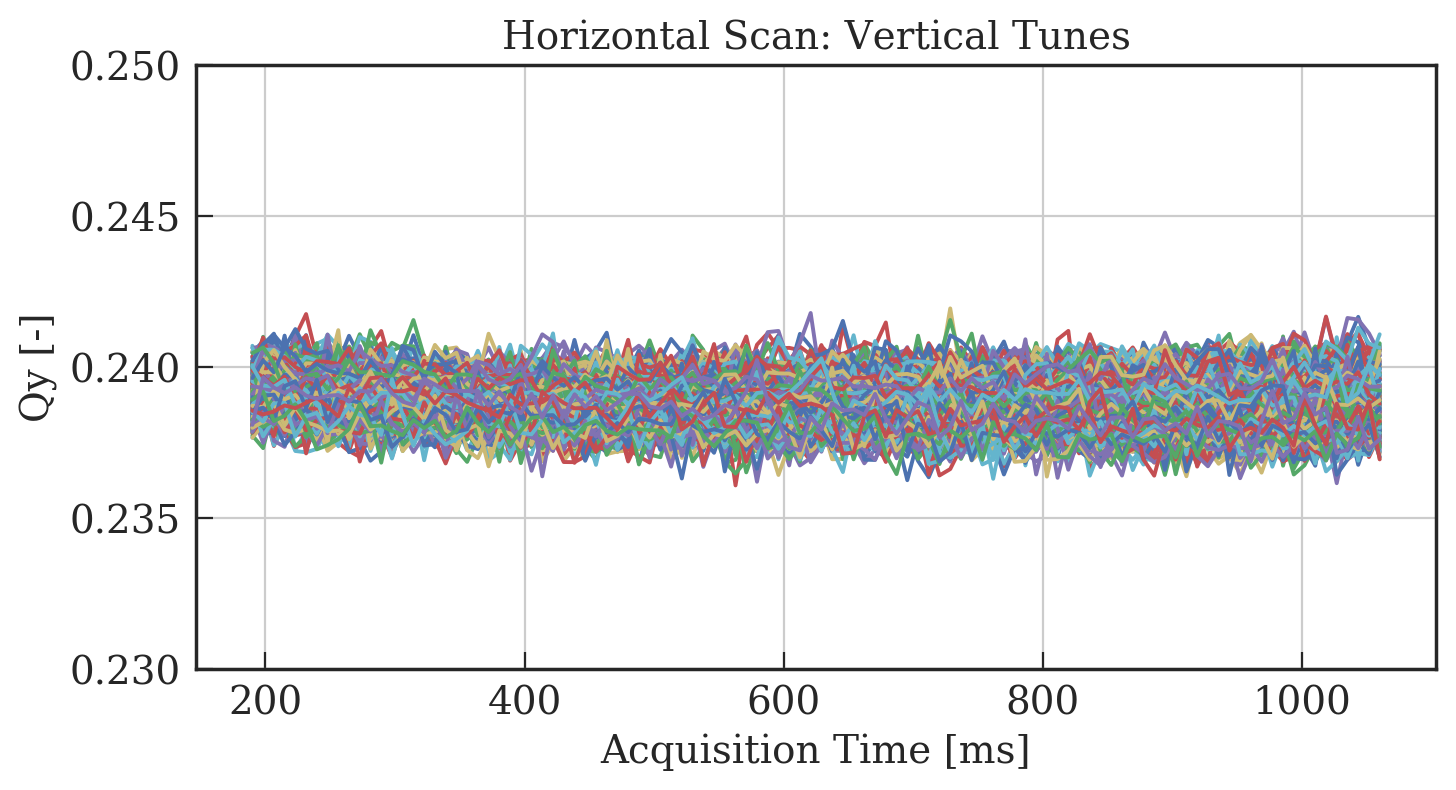

In [163]:
# Plot all Vertical tune measurements
fig=plt.figure(figsize=(8, 4), dpi= 200, facecolor='w', edgecolor='k')
df_tune_meas.apply(lambda x: plt.plot(sequence, x['PR_BQS72.SamplerAcquisition.value.estimatedTuneV']),axis=1)
plt.xlabel('Acquisition Time [ms]')
plt.ylabel('Qy [-]')
plt.legend()
plt.title('Horizontal Scan: Vertical Tunes')
plt.grid()
plt.ylim(0.23, 0.25)
fig.savefig('MD4224_Horizontal_QY.png')

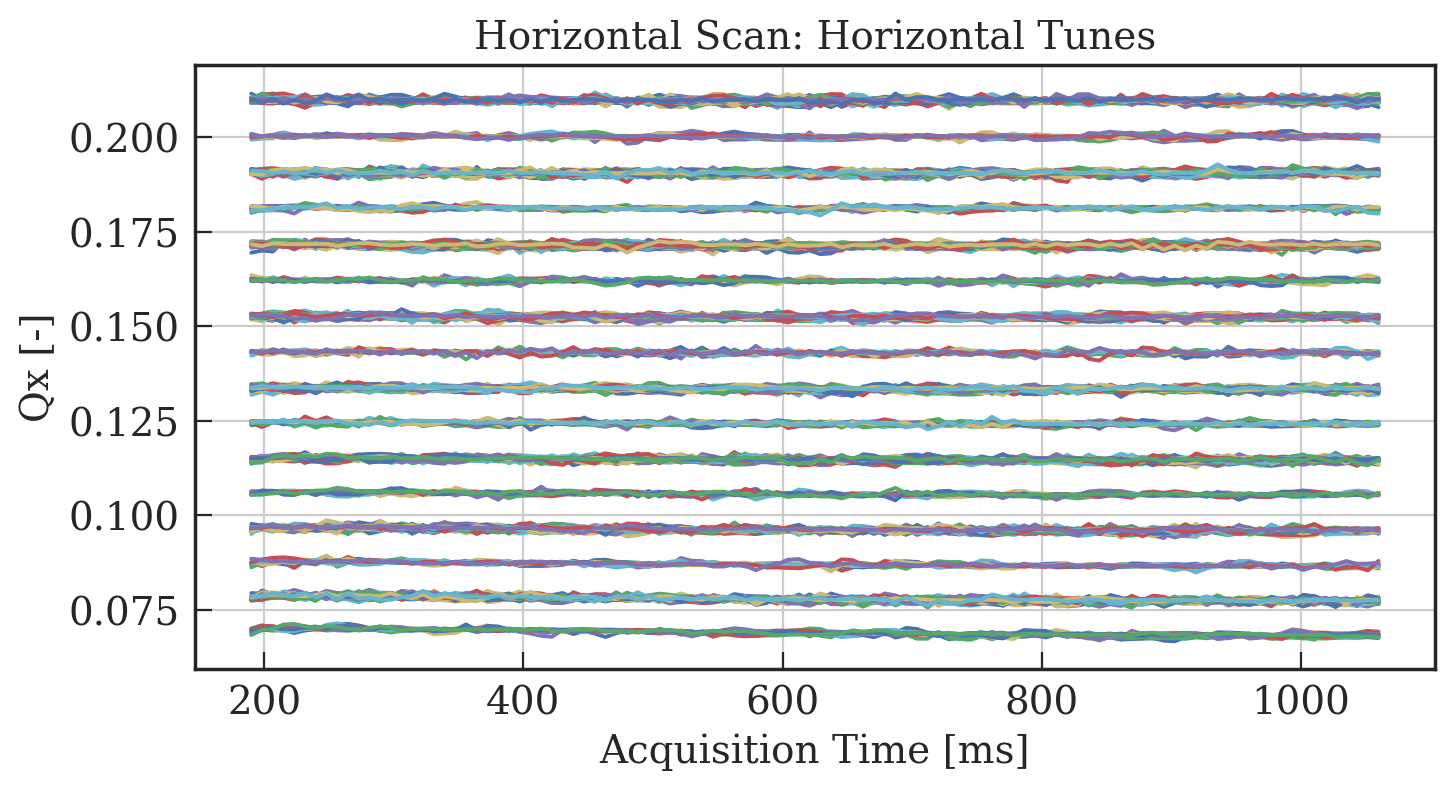

In [162]:
# Plot all Horizontal tune measurements
fig=plt.figure(figsize=(8, 4), dpi= 200, facecolor='w', edgecolor='k')
df_tune_meas2.apply(lambda x: plt.plot(sequence, x['PR_BQS72.SamplerAcquisition.value.estimatedTuneH']),axis=1)
plt.xlabel('Acquisition Time [ms]')
plt.ylabel('Qx [-]')
plt.legend()
plt.title('Horizontal Scan: Horizontal Tunes')
plt.grid()
fig.savefig('MD4224_Horizontal_QX.png')        

In [13]:
df_intensity=fromMatlabToDataFrame(myFiles,['PR_BCT_ST.Samples.value.samples','PR_BCT_ST.Samples.cycleStamp'])
#df_intensity

In [14]:
df_intensity['PR_BCT_ST.Samples.cycleStamp']=df_intensity['PR_BCT_ST.Samples.cycleStamp']/1e9
df_intensity['PR_BCT_ST.Samples.cycleStamp']=df_intensity['PR_BCT_ST.Samples.cycleStamp'].apply(myToolbox.unixtime2datetimeVectorize)
df_intensity=df_intensity.set_index(['PR_BCT_ST.Samples.cycleStamp'])

In [15]:
df=pnd.merge(df_tune_meas, df_intensity, left_index=True, right_index=True, how='outer')

In [16]:
df_intensity=intensity_df(df,start=70,end=1185)

In [121]:
# Filter erroneous measurments
df_intensity = df_intensity.drop( df_intensity[df_intensity['Qx'] < .05].index )
df_intensity = df_intensity.drop( df_intensity[df_intensity['Qy'] < .23].index )

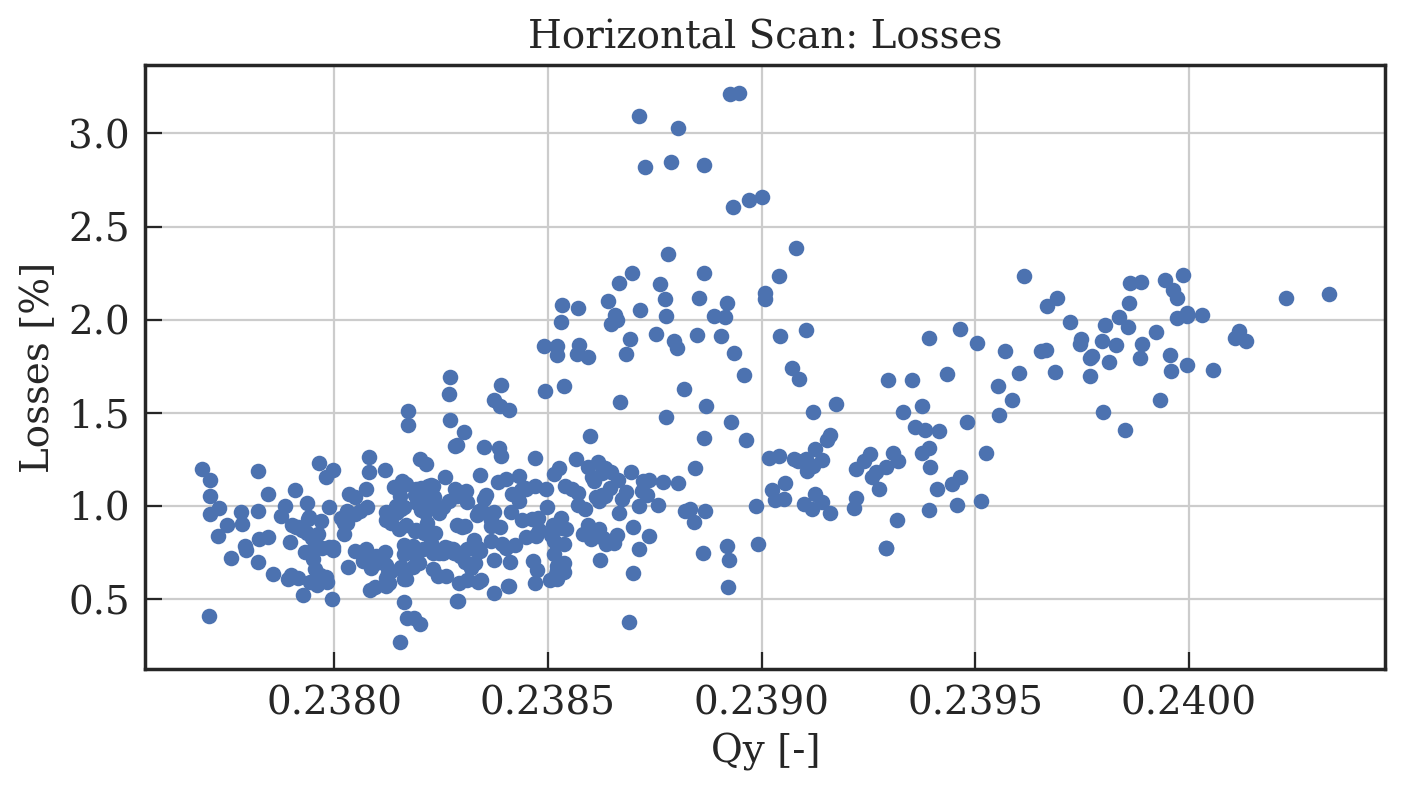

In [164]:
# Plot losses as a function of Vertical tune
fig=plt.figure(figsize=(8, 4), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(df_intensity['Qy'],df_intensity['losses'],'o')
plt.xlabel('Qy [-]')
plt.ylabel('Losses [%]')
plt.title('Horizontal Scan: Losses')
plt.grid()
fig.savefig('MD4224_Horizontal_Losses_Qy.png')

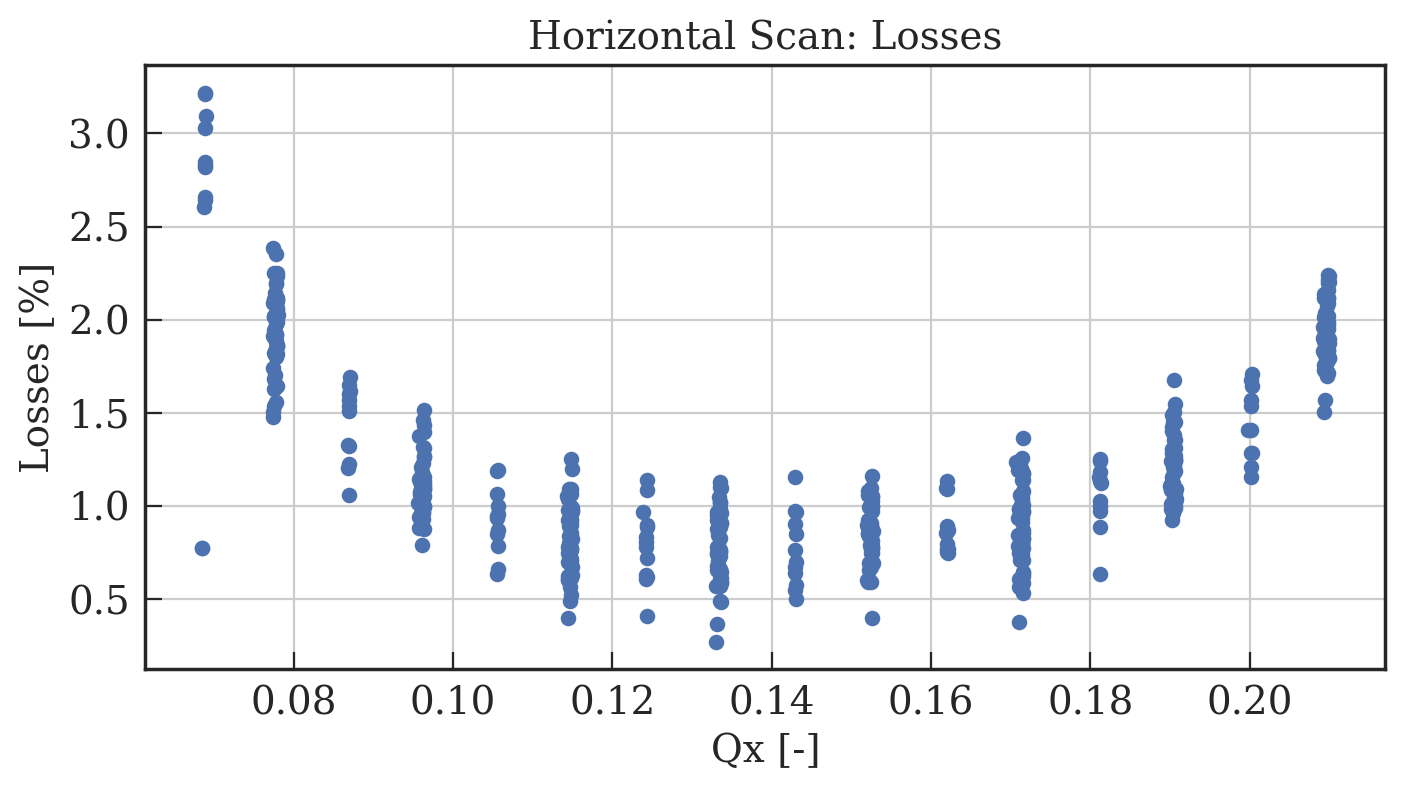

In [165]:
# Plot losses as a function of Vertical tune
fig=plt.figure(figsize=(8, 4), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(df_intensity['Qx'],df_intensity['losses'],'o')
plt.xlabel('Qx [-]')
plt.ylabel('Losses [%]')
plt.title('Horizontal Scan: Losses')
plt.grid()
fig.savefig('MD4224_Horizontal_Losses_Qx.png')

In [127]:
dfV=read_data(year=2018,date=4,month=9,hour=8,minutes=20,span=8,user='CPS%MD1',WS='65.H')

In [128]:
dfV=profiles(dfV,WS='65.H')
#dfV

In [129]:
# Filter erroneous measurements

# Add a column showing maximum profile height
def profile_max(ndf):
    df=ndf.copy()
    def maximum(a):
        return max(a)            
    df['profile_max']=df['PR.BWS.65.H_ROT:PROF_DATA_IN'].apply(maximum)
    return df

# Filter based on profile height
def many_filter(df_in):
    df=df_in.copy()    
    df_out = df.loc[~(df['profile_max'] > 3)]    
    return df_out

# Add profile_max column
df_test = profile_max(dfV)
# display rows with profile_max >= 4
df_test.loc[df_test['profile_max'] >= 4]

,PR.BWS.65.H_ROT:ACQ_DELAY,PR.BWS.65.H_ROT:PROF_POSITION_IN,PR.BCT.LT:SAMPLES,PR.BWS.65.H_ROT:PROF_DATA_IN,cycleStamp,profile H,position H,sig H,mu H,c H,A H,profile_max
2018-09-04 13:17:30.700,172.0,"[-51928.0, -51928.0, -51928.0, -51928.0, -5192...","[-0.12532, -0.1223, -0.11685, -0.10474, -0.095...","[0.176762519657, 0.177380571513, 0.17635168193...",1.536067e+18,NaN,"[-40.0, -39.9199199199, -39.8398398398, -39.75...",0.545606,-28.431896,0.190238,1.452474,5.757378


In [130]:
df_test2 = many_filter(df_test)
df_test2.loc[df_test['profile_max'] >= 4]
dfV = df_test2

2018-09-04 08:30:23.500      [Line2D(_line0)]
2018-09-04 08:31:07.900      [Line2D(_line1)]
2018-09-04 08:31:52.300      [Line2D(_line2)]
2018-09-04 08:33:21.100      [Line2D(_line3)]
2018-09-04 08:34:49.900      [Line2D(_line4)]
2018-09-04 08:36:18.700      [Line2D(_line5)]
2018-09-04 08:37:47.500      [Line2D(_line6)]
2018-09-04 08:39:16.300      [Line2D(_line7)]
2018-09-04 08:40:45.100      [Line2D(_line8)]
2018-09-04 08:42:13.900      [Line2D(_line9)]
2018-09-04 08:43:42.700     [Line2D(_line10)]
2018-09-04 08:45:11.500     [Line2D(_line11)]
2018-09-04 08:46:40.300     [Line2D(_line12)]
2018-09-04 08:48:09.100     [Line2D(_line13)]
2018-09-04 08:51:06.700     [Line2D(_line14)]
2018-09-04 08:52:35.500     [Line2D(_line15)]
2018-09-04 08:54:04.300     [Line2D(_line16)]
2018-09-04 08:55:33.100     [Line2D(_line17)]
2018-09-04 08:57:01.900     [Line2D(_line18)]
2018-09-04 08:58:30.700     [Line2D(_line19)]
2018-09-04 08:59:59.500     [Line2D(_line20)]
2018-09-04 09:01:28.300     [Line2

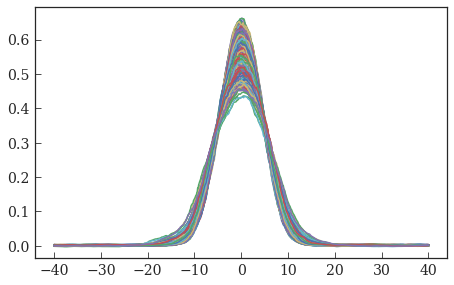

In [131]:
# Plot position vs profile
dfV.apply(lambda x: plt.plot(x['position H'], x['profile H']) , axis=1)

2018-09-04 08:30:23.500      [Line2D(_line0)]
2018-09-04 08:31:07.900      [Line2D(_line1)]
2018-09-04 08:31:52.300      [Line2D(_line2)]
2018-09-04 08:33:21.100      [Line2D(_line3)]
2018-09-04 08:34:49.900      [Line2D(_line4)]
2018-09-04 08:36:18.700      [Line2D(_line5)]
2018-09-04 08:37:47.500      [Line2D(_line6)]
2018-09-04 08:39:16.300      [Line2D(_line7)]
2018-09-04 08:40:45.100      [Line2D(_line8)]
2018-09-04 08:42:13.900      [Line2D(_line9)]
2018-09-04 08:43:42.700     [Line2D(_line10)]
2018-09-04 08:45:11.500     [Line2D(_line11)]
2018-09-04 08:46:40.300     [Line2D(_line12)]
2018-09-04 08:48:09.100     [Line2D(_line13)]
2018-09-04 08:51:06.700     [Line2D(_line14)]
2018-09-04 08:52:35.500     [Line2D(_line15)]
2018-09-04 08:54:04.300     [Line2D(_line16)]
2018-09-04 08:55:33.100     [Line2D(_line17)]
2018-09-04 08:57:01.900     [Line2D(_line18)]
2018-09-04 08:58:30.700     [Line2D(_line19)]
2018-09-04 08:59:59.500     [Line2D(_line20)]
2018-09-04 09:01:28.300     [Line2

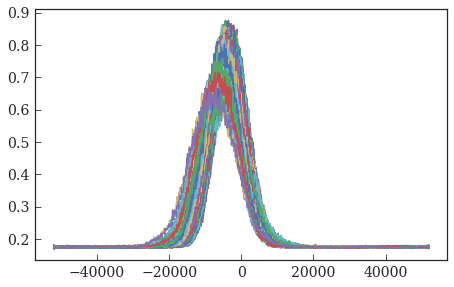

In [132]:
dfV.apply(lambda x: plt.plot( x['PR.BWS.65.H_ROT:PROF_POSITION_IN'],x['PR.BWS.65.H_ROT:PROF_DATA_IN']) ,axis=1)

In [136]:
df=pnd.merge(df_tune_meas,dfV,left_index=True, right_index=True, how='outer')
#df
# gives empty df for some reason
# df=df.dropna(axis=0,how='all',subset =['profile V'])
# print df

In [137]:
df=df.dropna(axis=0,how='all',subset =['Qx'])
df=df.dropna(axis=0,how='all',subset =['sig H'])
df=df.dropna(axis=1,how='all')
#df

In [138]:
dfV=df
#dfV

In [139]:
dfV['second_moment H']=dfV.apply(lambda x: second_moment_2(x['position H'], x['profile H'], x['sig H'], n_sigmas=6.), axis=1)

In [140]:
dfV=emittance_df(dfV, WS='65.H', dp=9E-4)
#dfV

Text(0,0.5,u'Emittance x [mm mrad]')

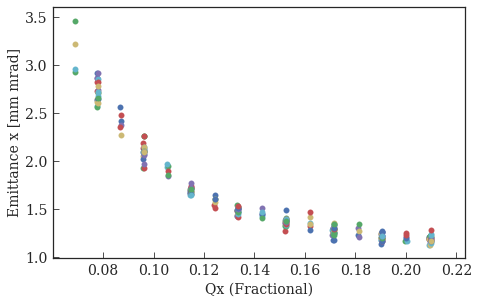

In [141]:
dfV.apply(lambda x: plt.scatter( x['Qx'], x['emittance H']) ,axis=1)
plt.xlabel('Qx (Fractional)')
plt.ylabel('Emittance x [mm mrad]')

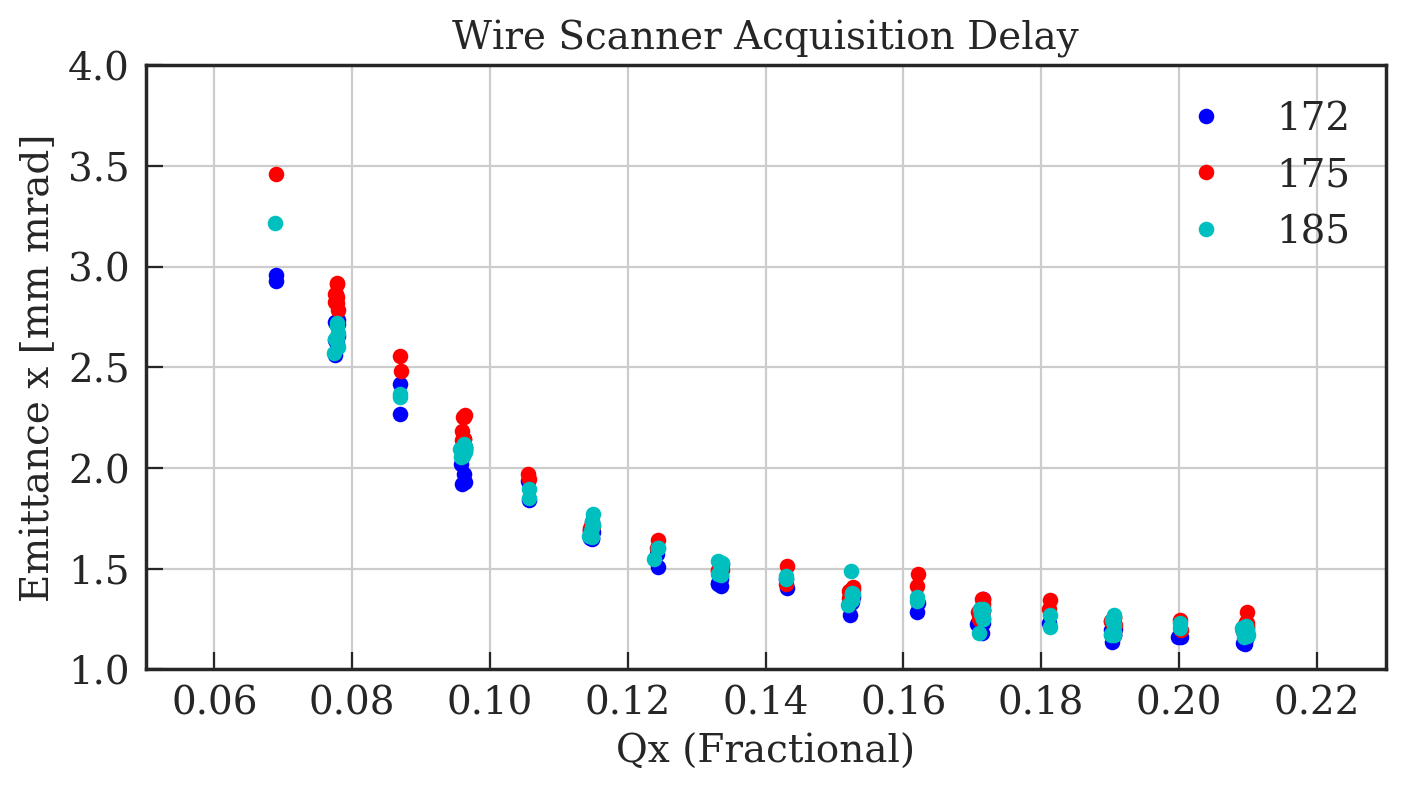

In [142]:
fig=plt.figure(figsize=(8, 4), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(dfV['Qx'][(dfV['PR.BWS.65.H_ROT:ACQ_DELAY']==172)], dfV['emittance H'][(dfV['PR.BWS.65.H_ROT:ACQ_DELAY']==172)],'bo', label='172')
plt.plot(dfV['Qx'][(dfV['PR.BWS.65.H_ROT:ACQ_DELAY']==175)], dfV['emittance H'][(dfV['PR.BWS.65.H_ROT:ACQ_DELAY']==175)],'ro', label='175')
plt.plot(dfV['Qx'][(dfV['PR.BWS.65.H_ROT:ACQ_DELAY']==185)], dfV['emittance H'][(dfV['PR.BWS.65.H_ROT:ACQ_DELAY']==185)],'co', label='185')
plt.xlabel('Qx (Fractional)')
plt.ylabel('Emittance x [mm mrad]')
plt.legend()
plt.title('Wire Scanner Acquisition Delay')
plt.xlim(0.05, 0.23)
plt.ylim(1,4)
plt.grid()
fig.savefig('MD4224_Horizontal_WS_Delay_Emittance.png')

Text(0.5,1,u'Wire Scanner Acquisition Delay')

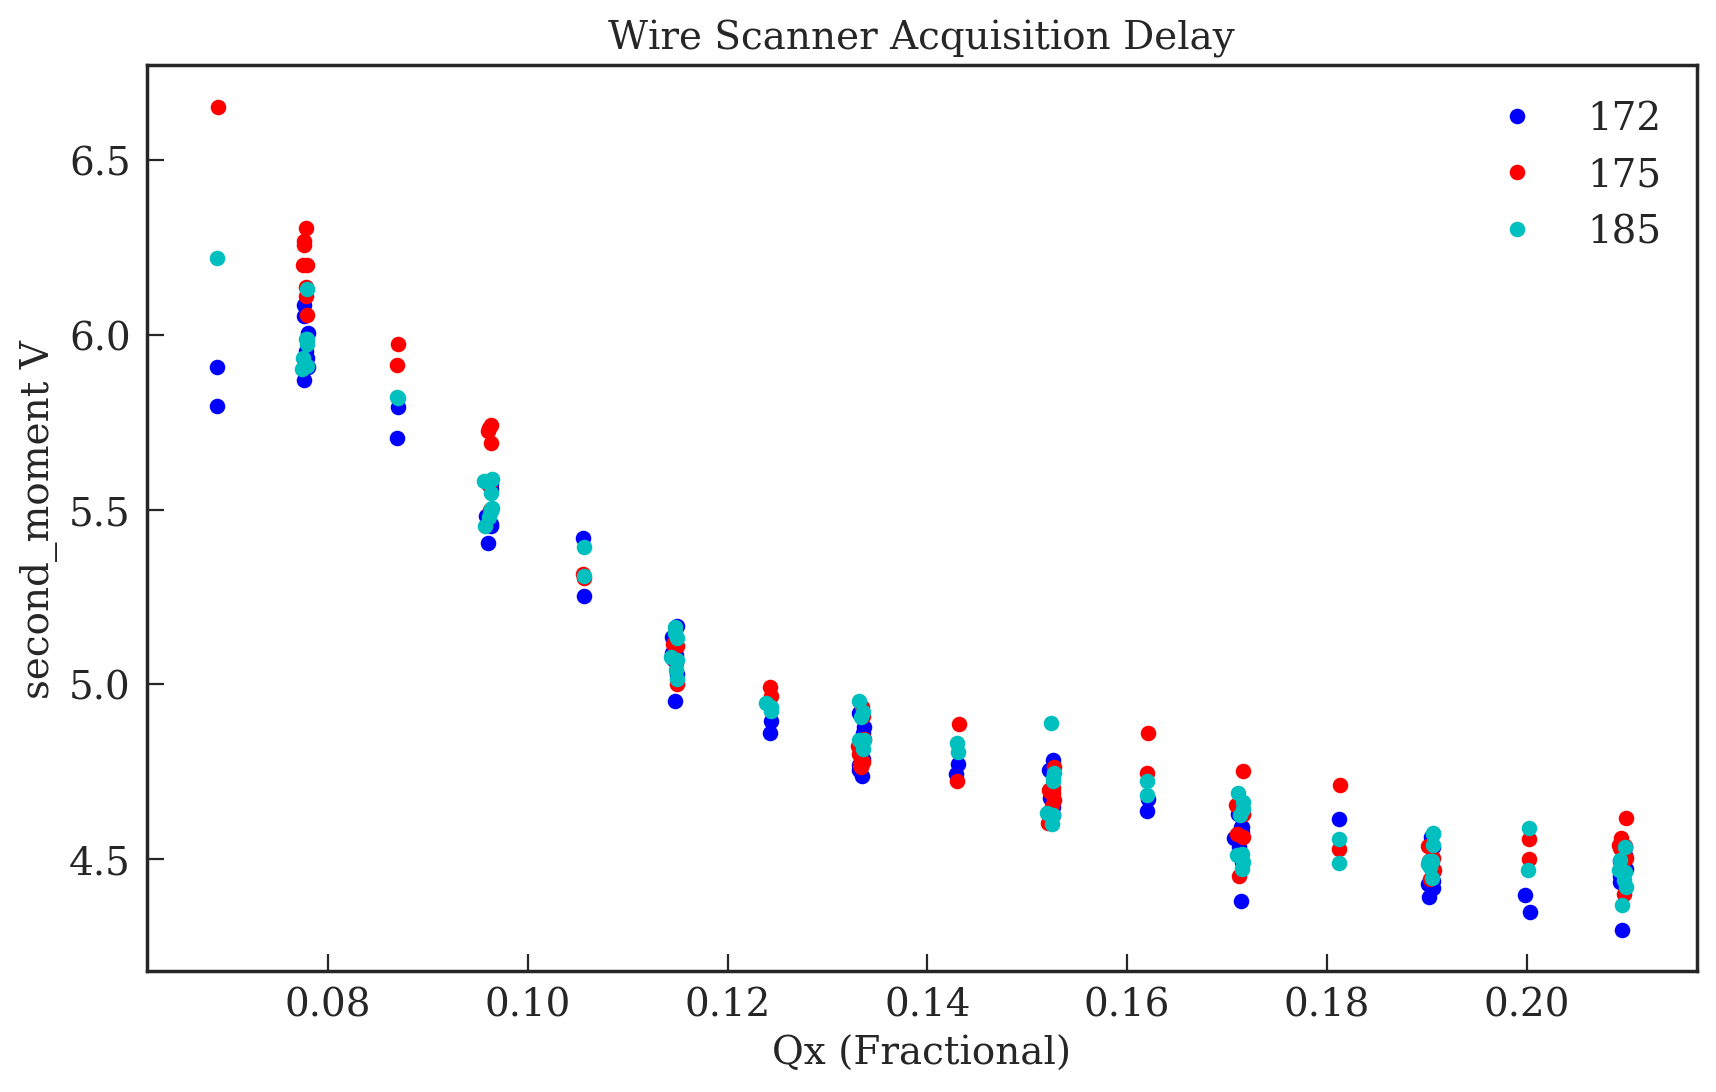

In [143]:
fig=plt.figure(figsize=(10, 6), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(dfV['Qx'][(dfV['PR.BWS.65.H_ROT:ACQ_DELAY']==172)], dfV['second_moment H'][(dfV['PR.BWS.65.H_ROT:ACQ_DELAY']==172)],'bo', label='172')
plt.plot(dfV['Qx'][(dfV['PR.BWS.65.H_ROT:ACQ_DELAY']==175)], dfV['second_moment H'][(dfV['PR.BWS.65.H_ROT:ACQ_DELAY']==175)],'ro', label='175')
plt.plot(dfV['Qx'][(dfV['PR.BWS.65.H_ROT:ACQ_DELAY']==185)], dfV['second_moment H'][(dfV['PR.BWS.65.H_ROT:ACQ_DELAY']==185)],'co', label='185')
plt.xlabel('Qx (Fractional)')
plt.ylabel('second_moment V')
plt.legend()
plt.title('Wire Scanner Acquisition Delay')

(0.23, 0.25)

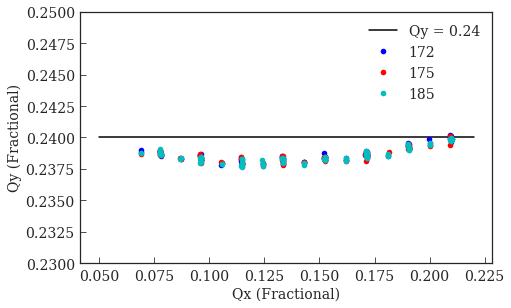

In [144]:
plt.plot([0.05, .22], [.24, .24], 'k-', lw=1.5, label='Qy = 0.24')
plt.plot(dfV['Qx'][(dfV['PR.BWS.65.H_ROT:ACQ_DELAY']==172)], dfV['Qy'][(dfV['PR.BWS.65.H_ROT:ACQ_DELAY']==172)],'bo', label='172')
plt.plot(dfV['Qx'][(dfV['PR.BWS.65.H_ROT:ACQ_DELAY']==175)], dfV['Qy'][(dfV['PR.BWS.65.H_ROT:ACQ_DELAY']==175)],'ro', label='175')
plt.plot(dfV['Qx'][(dfV['PR.BWS.65.H_ROT:ACQ_DELAY']==185)], dfV['Qy'][(dfV['PR.BWS.65.H_ROT:ACQ_DELAY']==185)],'co', label='185')
plt.xlabel('Qx (Fractional)')
plt.ylabel('Qy (Fractional)')
plt.legend()
plt.ylim(0.23, 0.25)